<h2>2.1</h2>


In [19]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device("cpu")

device

'cuda'

<h3>Data prep (from the previous question)</h3>


In [20]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


X = torch.zeros((8000 + 8000, 3, 128, 128), dtype=torch.uint8)
# X_finetune = torch.zeros((1600 + 1600, 3, 128, 128), dtype=torch.float16)

folder = ImageFolder("./TRAIN/")

print(f'Cache exists: {os.path.isfile("./TRAIN.tensorcache")}')
if not (os.path.isfile("./TRAIN.tensorcache")):
    common_transform = transforms.Compose([transforms.ToTensor()])
    augmented_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomAffine(degrees=20, translate=(0.10, 0.10), shear=30),
        ]  # rotation from -20 to 20 , translate %10 along both axes, and rotation along the x-axis
    )

    # finetune = torch.zeros((1600 + 1600, 3, 128, 128))

    X = torch.zeros((folder.__len__() * 2, 3, 128, 128), dtype=torch.uint8)
    image_paths = list(map(lambda item: item[0], folder.imgs))

    x_iterator = 0
    for i in range(0, image_paths.__len__(), 1):
        X[x_iterator] = common_transform(Image.open(image_paths[i])) * 255
        X[x_iterator + 1] = augmented_transform(Image.open(image_paths[i])) * 255
        x_iterator += 2

    torch.save(X, "TRAIN.tensorcache")
else:  # we have a cache available, don't need to read and transform images
    X = torch.load("TRAIN.tensorcache")

Cache exists: True


In [21]:
from sklearn.model_selection import train_test_split

classes = folder.classes

print(f"Classes: {classes}")

y = torch.zeros(16000, dtype=torch.uint8)

for i in range(classes.__len__()):
    y[i * 2000 : i * 2000 + 2000] = i
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


(torch.Size([10720, 3, 128, 128]),
 torch.Size([5280, 3, 128, 128]),
 torch.Size([10720]),
 torch.Size([5280]))

In [22]:
BATCH_SIZE = 400
train_loader = DataLoader(
    dataset=list(zip(X_train, y_train)), batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    dataset=list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=True
)

del X, y, X_train

# Network definition


In [23]:
class VGGNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        max_pool_stride = 2
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=max_pool_stride),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2, stride=max_pool_stride),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=max_pool_stride),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2, stride=max_pool_stride),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(True),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                padding=4,
            ),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2, stride=max_pool_stride),
            nn.Dropout2d(0.2),
        )
        self.flatten = nn.Flatten()
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(in_features=1024, out_features=8),
        )

    def forward(self, x: torch.Tensor):
        out = self.conv_layers(x)
        out = self.flatten(out)
        out = self.dense_layers(out)
        return out


model = VGGNet().to(device=device)

# Training


In [24]:
if not (os.path.isfile("./model.pytorchmodel")):  # already trained, skip
    print("No pretrained model, training from scratch...")
    torch.cuda.empty_cache()
    epochs = 24
    loss_function = nn.CrossEntropyLoss()
    alpha = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

    general_train_accuracy = []
    general_test_accuracy = []
    general_train_loss = []
    general_test_loss = []

    for epoch in range(epochs):
        train_accuracy = 0.0
        test_accuracy = 0.0
        train_loss = test_loss = 0.0
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device, dtype=torch.float), y_batch.to(
                device, torch.uint8
            )

            optimizer.zero_grad()

            y_logits = model(X_batch)
            y_logits_softmaxed = torch.softmax(y_logits, dim=1)
            predictions = torch.argmax(y_logits_softmaxed, dim=1).to(dtype=torch.uint8)
            train_accuracy += torch.count_nonzero(predictions == y_batch) / BATCH_SIZE

            loss = loss_function(y_logits, y_batch)

            train_loss += loss.item()

            loss.backward()

            optimizer.step()

            X_batch.detach_()
            y_batch.detach_()
            y_logits.detach_()
            predictions.detach_()

        del X_batch, y_batch, y_logits
        torch.cuda.empty_cache()

        with torch.inference_mode():
            model.eval()
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(
                    device=device, dtype=torch.float
                ), y_batch.to(device=device, dtype=torch.uint8)

                y_logits = model(X_batch)
                y_logits_softmaxed = torch.softmax(y_logits, dim=1)
                predictions = torch.argmax(y_logits_softmaxed, dim=1).to(
                    dtype=torch.uint8
                )

                loss = loss_function(y_logits, y_batch)

                test_loss += loss.item()

                test_accuracy += (
                    torch.count_nonzero(predictions == y_batch) / BATCH_SIZE
                )

                del X_batch, y_batch, y_logits, predictions
        general_train_accuracy.append(train_accuracy / (y_train.__len__() / BATCH_SIZE))
        general_test_accuracy.append(test_accuracy / (y_test.__len__() / BATCH_SIZE))
        general_train_loss.append(train_loss)
        general_test_loss.append(test_loss)
        print(
            f"Epoch: {epoch} | Loss: {loss.item()} | Test Loss: {test_loss} | Accuracy: {general_train_accuracy[-1]} | Test Accuracy: {general_test_accuracy[-1]}"
        )
    del train_loader, test_loader
    torch.save(model.state_dict(), "model.pytorchmodel")

No pretrained model, training from scratch...
Epoch: 0 | Loss: 2.090938091278076 | Test Loss: 29.412174940109253 | Accuracy: 0.15130597352981567 | Test Accuracy: 0.13162879645824432
Epoch: 1 | Loss: 1.7239853143692017 | Test Loss: 25.291820645332336 | Accuracy: 0.21119403839111328 | Test Accuracy: 0.22632576525211334
Epoch: 2 | Loss: 1.5904076099395752 | Test Loss: 23.656190752983093 | Accuracy: 0.26492539048194885 | Test Accuracy: 0.2617424428462982
Epoch: 3 | Loss: 1.6072269678115845 | Test Loss: 22.143132209777832 | Accuracy: 0.31072765588760376 | Test Accuracy: 0.3393939435482025
Epoch: 4 | Loss: 1.4149171113967896 | Test Loss: 20.93884289264679 | Accuracy: 0.3602612018585205 | Test Accuracy: 0.3969697058200836
Epoch: 5 | Loss: 1.2433063983917236 | Test Loss: 19.7522931098938 | Accuracy: 0.3929104208946228 | Test Accuracy: 0.42935606837272644
Epoch: 6 | Loss: 1.4441620111465454 | Test Loss: 19.54175055027008 | Accuracy: 0.42500001192092896 | Test Accuracy: 0.4416666626930237
Epoch:

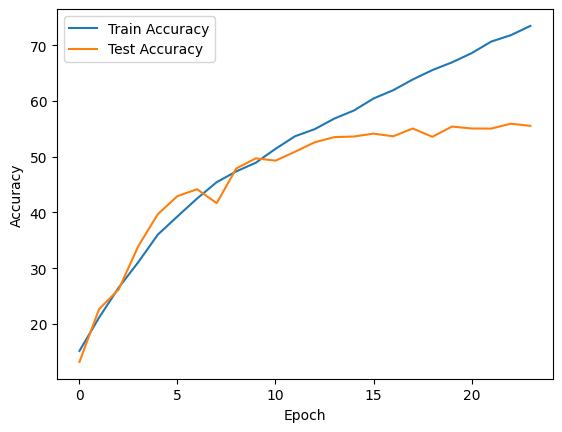

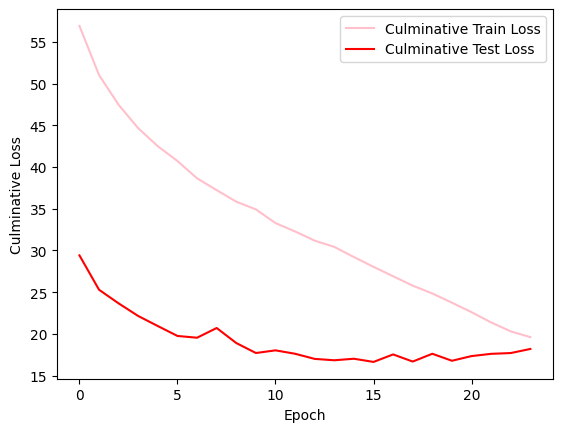

In [26]:
plt.plot(torch.tensor(general_train_accuracy) * 100.0, label="Train Accuracy")
plt.plot(torch.tensor(general_test_accuracy) * 100.0, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(torch.tensor(general_train_loss), label="Culminative Train Loss", c="pink")
plt.plot(torch.tensor(general_test_loss), label="Culminative Test Loss", c="red")
plt.xlabel("Epoch")
plt.ylabel("Culminative Loss")
plt.legend()
plt.show()

# Confusion Matrix


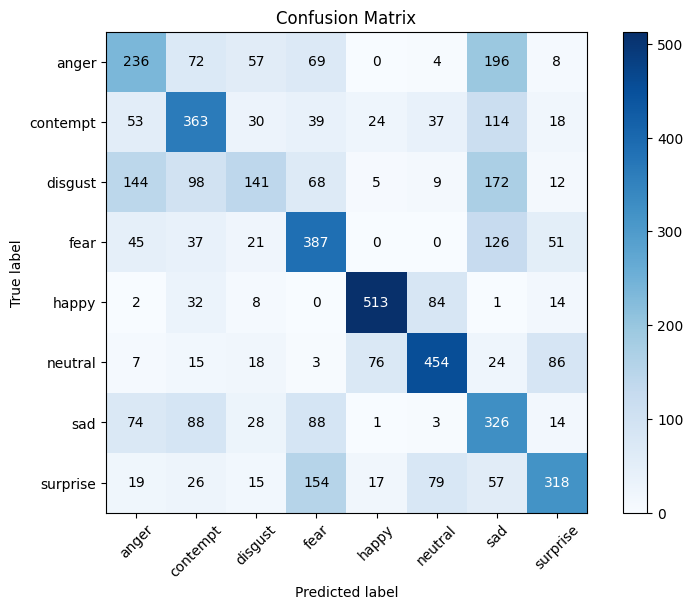

In [30]:
from sklearn.metrics import  confusion_matrix, roc_curve, auc
import numpy as np

model = VGGNet().to(device=device)
model.load_state_dict(torch.load('./model.pytorchmodel'))

test_loader = DataLoader(
    dataset=list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=True
)

y_true = []  # Ground truth
y_pred = []
with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.to(dtype=torch.float))
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = torch.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = "d"
thresh = confusion.max() / 2.0
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(
            j,
            i,
            format(confusion[i, j], fmt),
            ha="center",
            va="center",
            color="white" if confusion[i, j] > thresh else "black",
        )

plt.tight_layout()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# ROC Curve


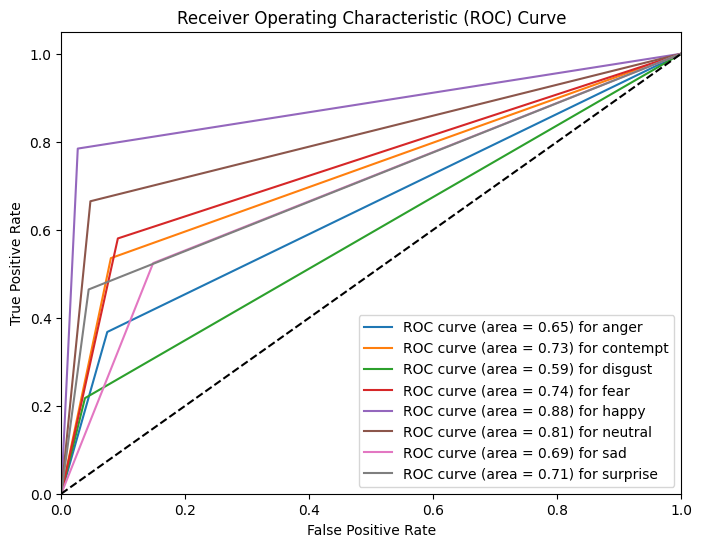

In [31]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
num_classes = len(classes)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), (np.array(y_pred) == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {classes[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

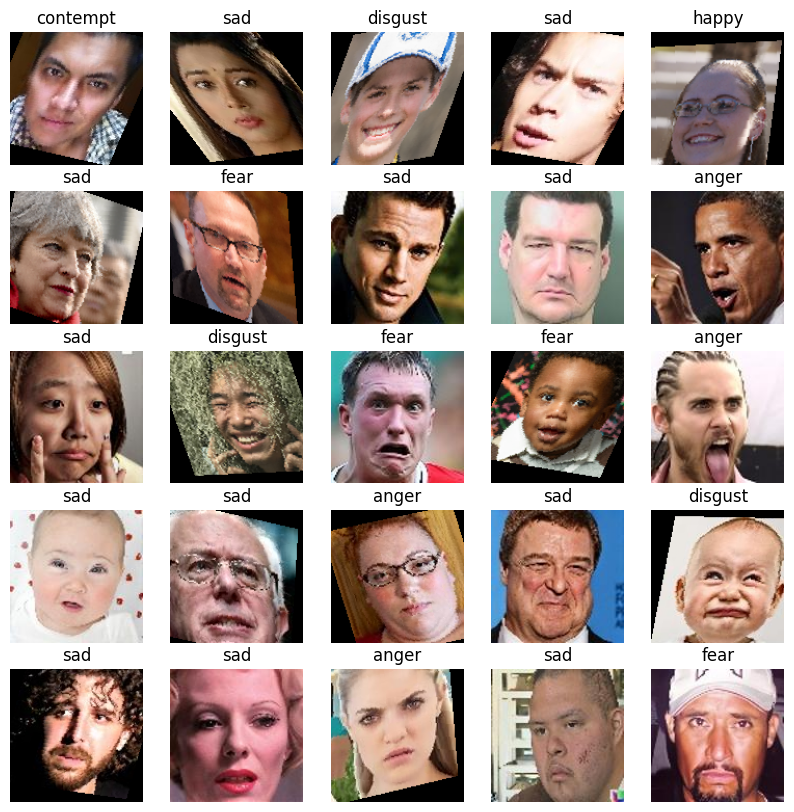

In [33]:
model.to(device='cpu')
_, ax = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        image_index = torch.randint(
            low=0, high=X_test.__len__(), size=(1,), dtype=int
        ).item()
        if image_index % 2 != 0:
            image_index -= 1

        prediction = torch.argmax(
            model(
                X_test[image_index].to(dtype=torch.float, device="cpu").unsqueeze(dim=0)
            ),
            dim=1,
        )
        # print(prediction)
        ax[i][j].imshow(
            X_test[image_index].to(dtype=torch.float).cpu().permute(1, 2, 0) / 255
        )
        ax[i][j].axis("off")
        ax[i][j].set_title(classes[prediction])

# Fine-Tuning


In [34]:
common_transform = transforms.Compose([transforms.ToTensor()])
augmented_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomAffine(degrees=20, translate=(0.10, 0.10), shear=30),
    ]  # rotation from -20 to 20 , translate %10 along both axes, and rotation along the x-axis
)

folder = ImageFolder("./TUNE/")

X = torch.zeros((folder.__len__(), 3, 128, 128), dtype=torch.uint8)
image_paths, y = list(map(lambda item: item[0], folder.imgs)), torch.tensor(
    list(map(lambda item: item[1], folder.imgs)), dtype=torch.uint8
)

for i in range(0, image_paths.__len__(), 1):
    X[i] = common_transform(Image.open(image_paths[i])) * 255


X.shape, y.shape

(torch.Size([1600, 3, 128, 128]), torch.Size([1600]))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

BATCH_SIZE = 400
train_loader = DataLoader(
    dataset=list(zip(X_train, y_train)), batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    dataset=list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=True
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1072, 3, 128, 128]),
 torch.Size([528, 3, 128, 128]),
 torch.Size([1072]),
 torch.Size([528]))

In [36]:
model = VGGNet().to(device=device)
model.load_state_dict(torch.load("./model.pytorchmodel"))
torch.cuda.empty_cache()
epochs = 16
loss_function = nn.CrossEntropyLoss()
alpha = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

general_train_accuracy = []
general_test_accuracy = []
general_train_loss = []
general_test_loss = []

for epoch in range(epochs):
    train_accuracy = 0.0
    test_accuracy = 0.0
    train_loss = test_loss = 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device, dtype=torch.float) / 255, y_batch.to(
            device, torch.uint8
        )

        optimizer.zero_grad()

        y_logits = model(X_batch)
        y_logits_softmaxed = torch.softmax(y_logits, dim=1)
        predictions = torch.argmax(y_logits_softmaxed, dim=1).to(dtype=torch.uint8)
        train_accuracy += torch.count_nonzero(predictions == y_batch) / BATCH_SIZE

        loss = loss_function(y_logits, y_batch)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        X_batch.detach_()
        y_batch.detach_()
        y_logits.detach_()
        predictions.detach_()

    del X_batch, y_batch, y_logits
    torch.cuda.empty_cache()

    with torch.inference_mode():
        model.eval()
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(
                device=device, dtype=torch.float
            ) / 255, y_batch.to(device=device, dtype=torch.uint8)

            y_logits = model(X_batch)
            y_logits_softmaxed = torch.softmax(y_logits, dim=1)
            predictions = torch.argmax(y_logits_softmaxed, dim=1).to(dtype=torch.uint8)

            test_loss = loss_function(y_logits, y_batch)

            test_loss += test_loss.item()

            test_accuracy += torch.count_nonzero(predictions == y_batch) / BATCH_SIZE

            del X_batch, y_batch, y_logits, predictions
    general_train_accuracy.append(train_accuracy / (y_train.__len__() / BATCH_SIZE))
    general_test_accuracy.append(test_accuracy / (y_test.__len__() / BATCH_SIZE))
    general_train_loss.append(train_loss)
    general_test_loss.append(test_loss)
    print(
        f"Epoch: {epoch} | Loss: {loss.item()} | Test Loss: {test_loss} | Accuracy: {general_train_accuracy[-1]} | Test Accuracy: {general_test_accuracy[-1]}"
    )
del train_loader, test_loader

Epoch: 0 | Loss: 1.8163018226623535 | Test Loss: 4.436374187469482 | Accuracy: 0.3712686598300934 | Test Accuracy: 0.13446968793869019
Epoch: 1 | Loss: 1.524035930633545 | Test Loss: 4.135469913482666 | Accuracy: 0.42257457971572876 | Test Accuracy: 0.15719695389270782
Epoch: 2 | Loss: 1.4928243160247803 | Test Loss: 4.184532165527344 | Accuracy: 0.42630597949028015 | Test Accuracy: 0.15909090638160706
Epoch: 3 | Loss: 1.468271017074585 | Test Loss: 4.717665672302246 | Accuracy: 0.46455222368240356 | Test Accuracy: 0.1553030163049698
Epoch: 4 | Loss: 1.363403558731079 | Test Loss: 4.720999240875244 | Accuracy: 0.4822761118412018 | Test Accuracy: 0.1818181872367859
Epoch: 5 | Loss: 1.1292473077774048 | Test Loss: 5.085172653198242 | Accuracy: 0.5177238583564758 | Test Accuracy: 0.17424242198467255
Epoch: 6 | Loss: 1.1943341493606567 | Test Loss: 4.777144432067871 | Accuracy: 0.5643656849861145 | Test Accuracy: 0.15340907871723175
Epoch: 7 | Loss: 0.9835116267204285 | Test Loss: 6.044355

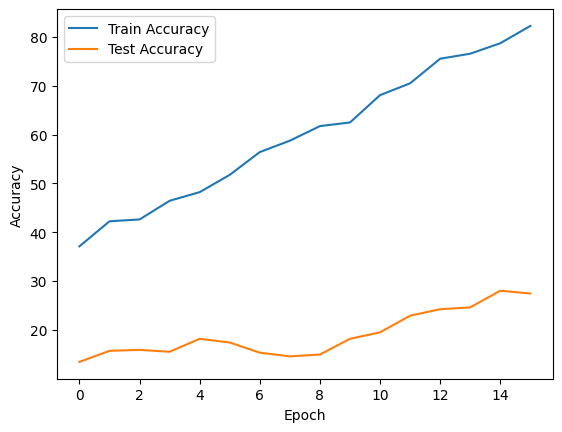

In [40]:
plt.plot(torch.tensor(general_train_accuracy) * 100.0, label="Train Accuracy")
plt.plot(torch.tensor(general_test_accuracy) * 100.0, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Fine-Tuned Confusion Matrix

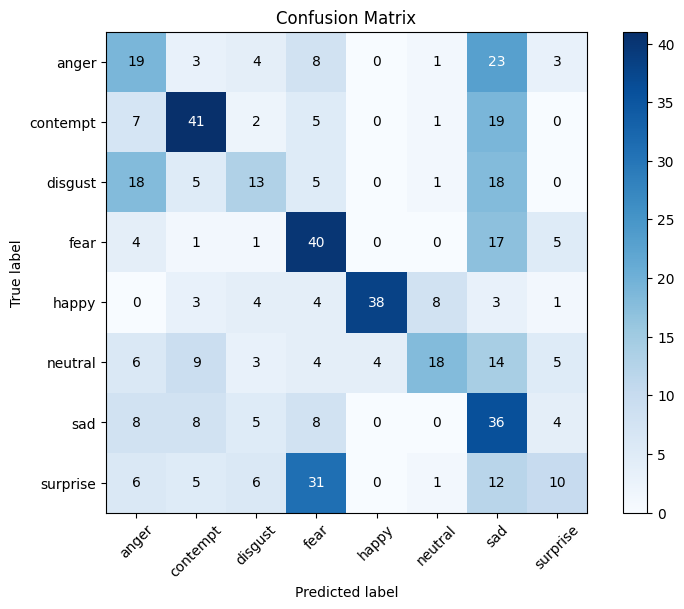

In [41]:
from sklearn.metrics import  confusion_matrix, roc_curve, auc
import numpy as np

model = VGGNet().to(device=device)
model.load_state_dict(torch.load('./model.pytorchmodel'))

test_loader = DataLoader(
    dataset=list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=True
)

y_true = []  # Ground truth
y_pred = []
with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.to(dtype=torch.float))
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = torch.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = "d"
thresh = confusion.max() / 2.0
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(
            j,
            i,
            format(confusion[i, j], fmt),
            ha="center",
            va="center",
            color="white" if confusion[i, j] > thresh else "black",
        )

plt.tight_layout()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Fine-tuned ROC Curve

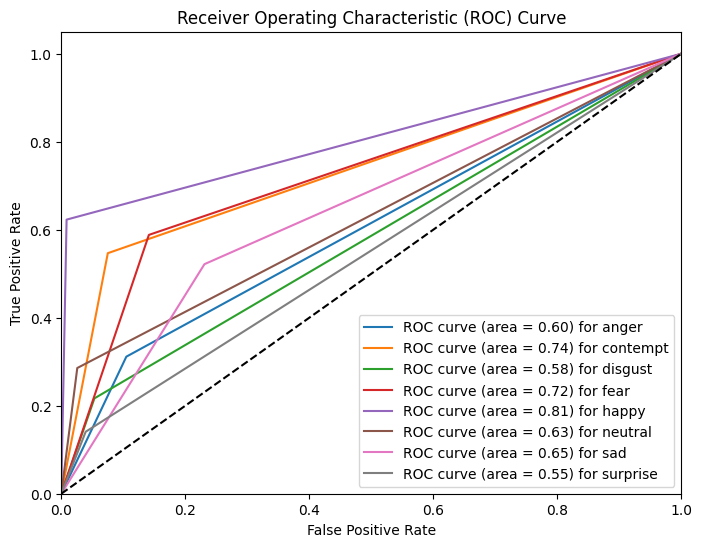

In [48]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
num_classes = len(classes)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), (np.array(y_pred) == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {classes[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()